In [3]:
import signac
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, sem
from tqdm import tqdm
import pandas as pd
from scipy.interpolate import CubicSpline
import scienceplots
plt.style.use(['science','no-latex'])

# project = signac.get_project('/data/yang_lab/nehilpkd/biomatsims/simulations/smd/fibril/prev_runs/')
project = signac.get_project('/data/yang_lab/nehilpkd/fiberForge/simulations/smd/bending')

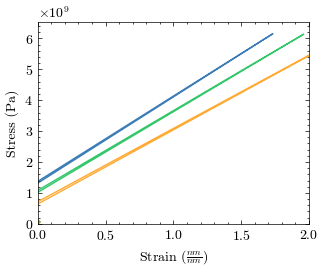

(1000000.0, 1000000000000.0)

<Figure size 350x262.5 with 0 Axes>

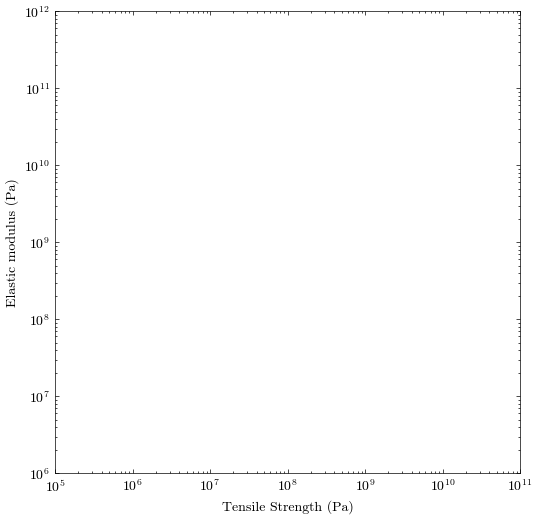

In [4]:
for job in project:
    if 'stress' in job.doc:
        try:
            if np.isclose(job.doc.get('ultimate_tensile_strength'), 0.0) or sum(np.array(job.doc.get('strain')) > 40.0) > 0:
            # if np.isclose(job.doc.get('ultimate_tensile_strength'), 0.0):
                continue
            stress = np.array(job.doc.get('stress'))
            plt.plot(np.array(job.doc['strain']), np.array(stress), label=job.sp.pdbID, alpha=.8)
        except:
            print(f'Error in {job.sp.pdbID}')
plt.xlabel('Strain $(\\frac{nm}{nm})$')
plt.ylabel('Stress (Pa)')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0)
plt.xlim(0,2)
plt.savefig('stress_strain.png', dpi=600)
plt.show()
plt.close()

# Ashby plot
plt.figure()
#change aspect ratio
plt.figure(figsize=(6, 6))

for job in project:
    if 'stress' in job.doc:
        try:
            if np.isclose(job.doc.get('ultimate_tensile_strength'), 0.0) or sum(np.array(job.doc.get('strain')) > 40.0) > 0:
                continue
            plt.scatter(np.array(job.doc['ultimate_tensile_strength']), np.array(job.doc['elastic_modulus']), label=job.sp.pdbID, edgecolors='k', color = 'black')
        except:
            print(f'Error in {job.sp.pdbID}')
plt.xlabel('Tensile Strength (Pa)')
plt.ylabel('Elastic modulus (Pa)')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e5, 1e11)
plt.ylim(1e6, 1e12)
# plt.yticks([])
# plt.xticks([])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/tmp/ipykernel_10927/194526722.py:47: RuntimeWarning: invalid value encountered in scalar divide
  E = (y_fine[inflection_points][0] - y_fine[0]) / (x_fine[inflection_points][0] - x_fine[0])


PDB 2MXU
E = nan


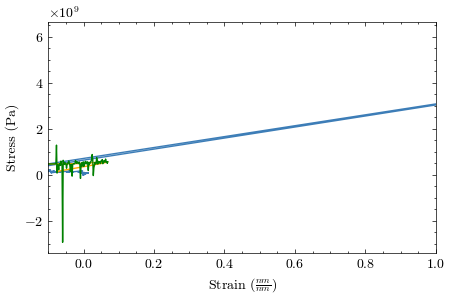

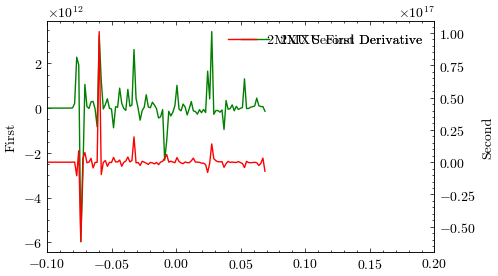

In [5]:
pdbs = ['2MXU', '7YPG', '6GK3', '8SBD', '2N0A']
# pdbs = ['6Y1A']
# pdbs = pdbs[3]

sub = project.find_jobs({"sp.pdbID": {"$in": pdbs}})
visited = []
for i, job in enumerate(sub):
    if 'stress' in job.doc:
        # try:
            if np.isclose(job.doc.get('ultimate_tensile_strength'), 0.0) or sum(np.array(job.doc.get('strain')) > 40.0) > 0:
                continue
            if job.sp.pdbID in visited:
                continue
            visited.append(job.sp.pdbID)
            stress = np.array(job.doc.get('stress'))
            strain = np.array(job.doc['strain'])

            window_size = 400
            df = pd.DataFrame({'strain': strain, 'stress': stress})
            moving_avg = df.rolling(window=window_size).mean()
            moving_avg = moving_avg.dropna()
            

            args = np.argsort(moving_avg['strain']).values
            x = moving_avg['strain'].values[args]
            y = moving_avg['stress'].values[args]

            # Create a cubic spline
            cs = CubicSpline(x, y)

            # Calculate the first derivative of the spline
            cs_derivative = cs.derivative()

            # Create a fine grid of x values for smooth plotting
            x_fine = np.linspace(x.min(), x.max(), 2000)
            y_fine = cs(x_fine)
            dy_dx_fine = cs_derivative(x_fine)
            dy2_dx2_fine = cs_derivative.derivative()(x_fine)

            delta_stress = np.diff(y)
            delta_strain = np.diff(x)
            delta_first = delta_stress/delta_strain
            strain_mid = (moving_avg['strain'][:-1] + moving_avg['strain'][1:]) / 2

            inflection_points = np.isclose(dy2_dx2_fine, 0.0, atol=1e11) == 1

            E = (y_fine[inflection_points][0] - y_fine[0]) / (x_fine[inflection_points][0] - x_fine[0])
            print(f"PDB {job.sp.pdbID}")
            print(f'E = {E/1e9}')
            
            plt.figure(figsize=(5, 3))
            plt.plot(strain, stress, label=job.sp.pdbID, alpha=.8)
            plt.plot(moving_avg['strain'], moving_avg['stress'], label=f'{job.sp.pdbID} Moving Average', color='orange')
            plt.plot(x_fine, y_fine, label=f'{job.sp.pdbID} Cubic Spline', color='green')
            plt.axvline(x=x_fine[inflection_points][0], color='red', linestyle='--')
            plt.xlim(-.1,1)
            plt.xlabel('Strain $(\\frac{nm}{nm})$')
            plt.ylabel('Stress (Pa)')
            plt.show()

            plt.figure(figsize=(5, 3))
            ax1 = plt.subplot(111)
            ax1.plot(x_fine, dy_dx_fine, label=f'{job.sp.pdbID} First Derivative', color='green')
            ax1.set_ylabel('First')
            ax1.legend()
            ax2 = ax1.twinx()
            ax2.set_ylabel('Second')
            ax2.plot(x_fine, dy2_dx2_fine, label=f'{job.sp.pdbID} Second Derivative', color='red')
            ax2.legend(loc='upper right')
            plt.xlim(-.1,.2)
            plt.show()
        # except:
        #     print(f'Error in {job.sp.pdbID}')


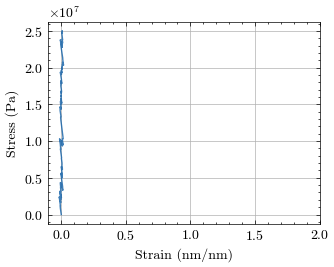

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Example data
pdbs = ['6Y1A']

# Assuming the rest of the code remains the same as in your snippet...

# Iterate over jobs
for job in sub:
    if 'stress' in job.doc:
        if np.isclose(job.doc.get('ultimate_tensile_strength'), 0.0) or sum(np.array(job.doc.get('strain')) > 40.0) > 0:
            continue
        if job.sp.pdbID in visited:
            continue
        visited.append(job.sp.pdbID)
        stress = np.array(job.doc.get('stress'))
        strain = np.array(job.doc['strain'])

        window_size = 200
        df = pd.DataFrame({'strain': strain, 'stress': stress})
        moving_avg = df.rolling(window=window_size).mean()
        moving_avg = moving_avg.dropna()

        args = np.argsort(moving_avg['strain']).values
        x = moving_avg['strain'].values[args]
        y = moving_avg['stress'].values[args]

        delta_stress = np.diff(y)
        delta_strain = np.diff(x)
        delta_first = delta_stress / delta_strain
        delta_first = np.nan_to_num(delta_first)
        strain_mid = (moving_avg['strain'][:-1] + moving_avg['strain'][1:]) / 2

        # Plot stress-strain curve and moving average
        plt.plot(strain, stress, label=job.sp.pdbID, alpha=0.8)
        plt.plot(moving_avg['strain'], moving_avg['stress'], label=f'{job.sp.pdbID} Moving Average', color='orange')
        plt.xlim(-0.1, 2)

        # Create a twin Axes sharing the xaxis
        # ax2 = plt.gca().twinx()

        # # Plot the first derivative on the right axis
        # ax2.plot(strain_mid[1:], delta_first, label=f'{job.sp.pdbID} First Derivative', color='green')
        # ax2.set_ylabel('First Derivative of Stress (Pa/nm)')
        # ax2.legend()

plt.xlabel('Strain (nm/nm)')
plt.ylabel('Stress (Pa)')
plt.xlim(-0.1, 2)
plt.grid(True)
plt.show()


In [7]:
# project.find_jobs({'sp.pdbID': '2MXU'})
subdf = project.find_jobs({"sp.pdbID": {"$in": ['2MXU', '7YPG', '6GK3', '8SBD', '2N0A']}}).to_dataframe()
subdf[['sp.pdbID', 'doc.cross_sectional_area',	'doc.strain',	'doc.stress',	'doc.ultimate_tensile_strength',	'doc.elastic_modulus']]

,sp.pdbID,doc.cross_sectional_area,doc.strain,doc.stress,doc.ultimate_tensile_strength,doc.elastic_modulus
2b407160c6f242cb999b4cc11619a515,2MXU,3.209223e-18,"[0.0, -0.005010844802296998, -0.00060465624317...","[-1.8151903206744133, 1112054.3267155564, 7198...",2.528846e+08,9.349574e+09
89d4bdea713ea33468c8094b3496db78,7YPG,3.930221e-18,"[0.0, -0.0043420029821787855, -0.0077446401798...","[2.8314948669184283, 793141.1909219171, 146976...",1.037860e+08,NaN
b38e3e1e4993d0566226ade6eb35eabf,6GK3,5.405033e-18,"[0.0, -0.006406106045994918, -0.00826632187797...","[3.3127088704498044, 790861.0701239773, 115182...",2.502446e+07,NaN
4cab69d8e350e1b991b0c725e0e667d5,7YPG,3.930221e-18,"[0.0, -0.0039397959077093385, -0.0070398261977...","[-0.7035050054265456, 734276.81352161, 1366208...",1.039336e+08,7.192380e+09
9e6ac1f11d1a90f9fc10f2d35092d9ef,6GK3,5.405033e-18,"[0.0, 0.00299056518869625, 0.00326993460130791...","[0.09985970909624133, -110129.02703915135, 473...",3.947377e+08,7.210531e+09
85025593fa91b935dad630ab0635bbe8,8SBD,NaN,NaN,NaN,NaN,NaN
c4a5792d2065aa0ba6d116a36b317003,8SBD,NaN,NaN,NaN,NaN,NaN
508bddaf1734379cbb4df8638360e581,6GK3,5.405033e-18,"[0.0, -0.0034730284033743348, 0.00110285581611...","[-1.6411630379652848, 517088.44687565975, 2646...",4.327818e+07,NaN
b10c23aab5dac4db8c60a6e46abb8300,2N0A,NaN,NaN,NaN,NaN,NaN
3a80a53daab156fb9e6672c2160c1733,6GK3,5.405033e-18,"[0.0, -0.006905148157313398, -0.00937061783386...","[-4.765132997193236, 881815.1902896168, 131572...",1.053605e+08,NaN


/home/nehilpkd/bin/miniconda3/envs/biomatsims/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 946 (\N{GREEK SMALL LETTER BETA}) missing from font(s) cmr10.
  func(*args, **kwargs)
/home/nehilpkd/bin/miniconda3/envs/biomatsims/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  func(*args, **kwargs)
/home/nehilpkd/bin/miniconda3/envs/biomatsims/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 945 (\N{GREEK SMALL LETTER ALPHA}) missing from font(s) cmr10.
  func(*args, **kwargs)
/home/nehilpkd/bin/miniconda3/envs/biomatsims/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 946 (\N{GREEK SMALL LETTER BETA}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nehilpkd/bin/miniconda3/envs/biomatsims/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cm

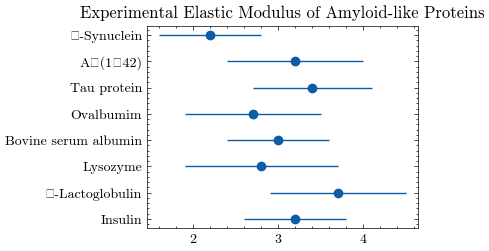

In [7]:
# experimental reports on similar β-sheet structures find the elastic modulus in the range of 10–30 GPa and the strength on the order of 100 MPa
simulated_results = [ # Tensile deformation and failure of amyloid and amyloid-like protein fibrils
    ['stacked aBeta (1-40)', 7.85, 5.46, 13.0, 242.6], # inital length (nm), cross-sectional area (nm2) Young’s modulus  (GPa) Ultimate tensile strength (MPa)
    ['Iowa mutant aBeta', 6.96, 3.64, 11.7, 402.3],
    ['Helical YadA CBP', 3.52, 1.40, 12.6, 553.7],
    ['LpIBP', 3.74, 1.89, 26.9, 693.4],
    ['GlmU C-terminus', 5.37, 2.20, 23.3, 629.8],
    ['Mixed HET-s prion', 5.38, 2.10, 9.8, 917.0],
]
experimental_results = [ # elastic modulus (GPa), certainty https://doi-org.proxy.library.vanderbilt.edu/10.1039/C2NR30768E
    ['Insulin', 3.2, 0.6], #8SBD  3dbf2ff171970a0eb7fc96b2b2025de7
    ['β-Lactoglobulin', 3.7, 0.8], #6GK3
    ['Lysozyme', 2.8, 0.9],
    ['Bovine serum albumin', 3.0, 0.6],
    ['Ovalbumim', 2.7, 0.8],
    ['Tau protein', 3.4, 0.7], #7YPG for (297-391) 7NRS
    ['Aβ(1–42)', 3.2, 0.8], # 2MXU
    ['α-Synuclein', 2.2, 0.6], #2N0A 7WO0
]
# plot with error bars and x axis text vertical
plt.title('Experimental Elastic Modulus of Amyloid-like Proteins')
plt.errorbar([e[1] for e in experimental_results], [e[0] for e in experimental_results], xerr=[e[2] for e in experimental_results], fmt='o')
# plt.plot([e[0] for e in experimental_results], [e[1] for e in experimental_results])

experimental_results = [  # elastic modulus (GPa), certainty
    ['α-Synuclein', 1.4, .4] #  https://doi.org/10.1002/polb.23428

]
experiment_results = [ # Tensile strength (GPa), uncertainty https://doi.org/10.1016/j.polymer.2013.02.029
    ['hiPP', 0.6, .4] # two prototfibrils
]
experimental = [ #fracture force (pN), uncertainty https://doi.org/10.1016/j.polymer.2013.02.029
    ['Aβ(1–42)', 23],
    ['Aβ(1–40)', 33],
]

In [6]:
def get_value_mean_sem(project_df, pdb, key):
    jobs = project_df[project_df['sp.pdbID'] == pdb]
    mean = np.mean(jobs[f'doc.{key}'])
    std_err = sem(jobs[f'doc.{key}'])
    if len(jobs) == 0:
        raise ValueError(f'No jobs found for {pdb}')
    if len(jobs) == 1:
        return mean, 0
    return mean, std_err

# pdbs = ['2MXU', '7YPG', '6GK3', '8SBD', '2N0A']
pdbs = ['2MXU', '7YPG', '6GK3', '8SBD', '6Y1A']
pdbs_to_name = {
    '2MXU': 'A$\\beta$(1–42)',
    '7YPG': 'Tau protein',
    '6GK3': '$\\beta$-Lactoglobulin',
    '8SBD': 'Insulin',
    '2N0A': '\\alpha-Synuclein',
    '6Y1A': 'hiPP'
}
pdb_to_exp = {
    '2MXU': 3.2,
    '7YPG': 3.4,
    '6GK3': 3.7,
    '8SBD': 3.2,
    '2N0A': 2.2,
    '6Y1A': 4.0
}
pdb_to_exp_err = {
    '2MXU': 0.8,
    '7YPG': 0.7,
    '6GK3': 0.8,
    '8SBD': 0.6,
    '2N0A': 0.6,
    '6Y1A': sem(np.array([2.89e9, 5.40e9, 3.44e9, 4.22e9, 3.43e9])/1e9)
}

subdf = project.find_jobs({"sp.pdbID": {"$in": ['2MXU', '6GK3', '2N0A', '7YPG', '6Y1A']}}).to_dataframe()
subdf2 = project.find_jobs({"sp.pdbID": {"$in": '8SBD'}, "sp.pull_chains":{'$in': [[0,1]]}}).to_dataframe()

sim_val, sim_err = {}, {}
for pdb in pdbs:
    if pdb == '8SBD':
        mean, error = get_value_mean_sem(subdf2, '8SBD', 'elastic_modulus')
        sim_val[pdb] = mean/1e9
        sim_err[pdb] = error/1e9

    else:
        mean, error = get_value_mean_sem(subdf, pdb, 'elastic_modulus')
        sim_val[pdb] = mean/1e9
        sim_err[pdb] = error/1e9


plt.figure(figsize=(8, 6))

for pdb in pdbs:
    real = pdb_to_exp[pdb]
    exp_err = pdb_to_exp_err[pdb]
    pred = sim_val[pdb]
    pred_err = sim_err[pdb]

    plt.errorbar(
        real, 
        pred, 
        yerr=pred_err, 
        xerr = exp_err, 
        fmt='o', 
        capsize=5, 
        label = pdbs_to_name[pdb] + f' ({pdb})'
    )



plt.plot([2, 6], [2, 6], 'k--')
plt.xlabel('$E_\\text{exp}$ (GPa)')
plt.ylabel('$E_\\text{sim}$ (GPa)')
plt.legend()
plt.show()

# # Calculating r-squared value
# correlation_matrix = np.corrcoef(sim_val, exp_val)
# correlation_xy = correlation_matrix[0,1]
# r_squared = correlation_xy**2

# # Calculating r value
# r_value = correlation_xy

# # Annotating the plot with r-squared and r values
# plt.text(2.5, 3.3, f'$r^2 = {r_squared:.2f}$', fontsize=12)
# plt.text(2.5, 3.2, f'$r = {r_value:.2f}$', fontsize=12)

# plt.plot([job.doc['ultimate_tensile_strength']/1e6 for job in project if job.sp.pdbID in ran_pdbs], [], 'o', label='Tensile strength (MPa)')
# plt.xlabel('predicted ultimate tensile strength (MPa)')
# plt.ylabel('experimental ultimate tensile strength (MPa)')

/home/nehilpkd/bin/miniconda3/envs/biomatsims/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/nehilpkd/bin/miniconda3/envs/biomatsims/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/nehilpkd/bin/miniconda3/envs/biomatsims/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: No jobs found for 7YPG

In [12]:
subdf = project.find_jobs({
    "sp.pdbID": {"$in": ['6GK3', '2N0A', '8SBD', '2MXU', '7YPG']},
    # "sp.pdbID": {"$in": ['2MXU']},
    # "sp.pdbID": {"$in": ['8SBD']},
    # "sp.pull_chains":{'$in': [[0,-1]]}
    # "sp.replicate": 1
}).to_dataframe()
# subdf['doc.elastic_modulus'].mean() / 1e9
# subdf[['sp.replicate','sp.pull_chains','sp.pdbID','doc.elastic_modulus']]
# subdf[['sp.pdbID', 'doc.cross_sectional_area',	'doc.strain',	'doc.stress',	'doc.ultimate_tensile_strength',	'doc.elastic_modulus']]
subdf

,sp.replicate,sp.fiberverse_directory,sp.type,sp.pull_chains,sp.pull_constant,sp.pull_steps,sp.pull_rate,sp.pdbID,sp.protofibril_distance_threshold,doc.protofibrils,...,doc.growth_axis,doc.pulling_length,doc.box_size,doc.cross_sectional_area,doc.strain,doc.stress,doc.ultimate_tensile_strength,doc.elastic_modulus,sp.n_repeats,doc.yield_point
1be7928dd9c9aff825bbb2e175464cf9,5,/data/yang_lab/nehilpkd/fibrilverse_rcsb,single,"[0, -1]",1000,250000,0.01,8SBD,20.0,"[{'A': [69.00108337402344, 70.89881134033203, ...",...,2,20.615,"[9.954, 10.854, 20.615000000000002]",2.847113e-18,"[0.0, 0.0017387133521194326, 0.003897116134060...","[15.750167070141687, -567757.6532055959, -1353...",4.137525e+08,6.131175e+08,NaN,NaN
099d5a5060eb8ed287e34d92fcd38833,1,/data/yang_lab/nehilpkd/fibrilverse_rcsb,single,"[0, -1]",1000,250000,0.01,2N0A,20.0,"[{'A': [105.10602569580078, 113.27666473388672...",...,2,81.595,"[31.864, 24.189999999999998, 81.595]",NaN,NaN,NaN,NaN,NaN,1.0,NaN
c4a5792d2065aa0ba6d116a36b317003,2,/data/yang_lab/nehilpkd/fibrilverse_rcsb,single,"[0, 1]",1000,250000,0.01,8SBD,20.0,"[{'A': [69.00108337402344, 70.89881134033203, ...",...,2,20.615,"[9.954, 10.854, 20.615000000000002]",2.847113e-18,"[0.0, 0.004779912467439687, -0.001077628951857...","[3.9446981404863974, -410837.27316596376, 8740...",7.649750e+08,5.421045e+09,NaN,NaN
4a9dd5eb6cdb4a48f0eeb9ee82beea4f,4,/data/yang_lab/nehilpkd/fibrilverse_rcsb,single,"[0, -1]",1000,250000,0.01,8SBD,20.0,"[{'A': [69.00108337402344, 70.89881134033203, ...",...,2,20.615,"[9.954, 10.854, 20.615000000000002]",2.847113e-18,"[0.0, -0.0012799744005119375, -0.0040732518682...","[-5.665704855700474, 1023366.6004849781, 28479...",4.901071e+08,3.647408e+08,NaN,NaN
feffb447bea6cc86afff31645937da56,2,/data/yang_lab/nehilpkd/fibrilverse_rcsb,single,"[0, -1]",1000,250000,0.01,8SBD,20.0,"[{'A': [69.00108337402344, 70.89881134033203, ...",...,2,20.615,"[9.954, 10.854, 20.615000000000002]",2.847113e-18,"[0.0, 0.0011546077881197684, 0.005831091846146...","[-14.386258974768454, -278009.72270042705, -24...",4.081855e+08,6.144780e+08,NaN,NaN
b40df395b4c067ff335cd429e6a257bc,4,/data/yang_lab/nehilpkd/fibrilverse_rcsb,single,"[0, 1]",1000,250000,0.01,8SBD,20.0,"[{'A': [69.00108337402344, 70.89881134033203, ...",...,2,20.615,"[9.954, 10.854, 20.615000000000002]",2.847113e-18,"[0.0, 0.00611261979739134, -0.0064542705366259...","[-1.9453849106630068, -748660.2244154186, 1863...",7.480350e+08,4.895959e+09,NaN,NaN
a0e92bcac086dca031f497c0b2916e7c,1,/data/yang_lab/nehilpkd/fibrilverse_rcsb,single,"[0, -1]",1000,250000,0.01,8SBD,20.0,"[{'A': [69.00108337402344, 70.89881134033203, ...",...,2,20.615,"[9.954, 10.854, 20.615000000000002]",2.847113e-18,"[0.0, -0.011788151930391268, -0.00592881085117...","[-1.7516377476093952, 2258417.8347772527, 1661...",6.495844e+08,3.036003e+09,1.0,NaN
5d93fcf0728d8bb16a6b31914d042abf,5,/data/yang_lab/nehilpkd/fibrilverse_rcsb,single,"[0, 1]",1000,250000,0.01,8SBD,20.0,"[{'A': [69.00108337402344, 70.89881134033203, ...",...,2,20.615,"[9.954, 10.854, 20.615000000000002]",2.847113e-18,"[0.0, -0.002811932710793225, -0.00608894880439...","[1.8808458417186225, 811903.2434854909, 170008...",6.958383e+08,1.518069e+09,NaN,NaN
24b406cbb90d0b5c72479bae14306986,0,/data/yang_lab/nehilpkd/fibrilverse_rcsb,single,"[0, 1]",1000,250000,0.01,2MXU,20.0,"[{'A': [-22.821231842041016, 8.70837116241455,...",...,2,32.850,"[13.694, 10.040000000000001, 32.85]",3.209223e-18,"[0.0, 0.0009399550316967308, -0.00544924687883...","[6.138371119862932, 147302.33540150078, 157696...",4.660256e+08,4.048885e+09,NaN,0.062831
b38e3e1e4993d0566226ade6eb35eabf,0,/data/yang_lab/nehilpkd/fibrilverse_rcsb,single,"[0, 1]",1000,250000,0.01,6GK3,20.0,"[{'A': [149.74058532714844, 135.4633026123047,...",...,2,12.620,"[15.777999999999999, 10.586, 12.620000000000001]",5.405033e-18,"[0.0, 0.0026785536893781025, 0.003903138585803...","[2.627125607933187, -89309.35677947477, -29902...",5.854359e+08,2.877352e+09,NaN,0.114660
